# Backup Frequencies

Large trucks make a beeping noise when backing up to safely warn pedestrians of an approaching vehicle.

Let's try to figure out what the frequencies are, and then make a best-effort to reproduce the sound.


In [916]:
import warnings
warnings.filterwarnings('ignore')


### Loading audio


In [917]:
import librosa
audio_path = './input/backing-up-scania-r580.wav'
x, sr = librosa.load(audio_path)

print(sr)
# Audio clip length
len(x)/sr


22050


3.0

### Playing audio


In [918]:
import IPython.display as ipd
ipd.Audio(audio_path)


## Waveform


(66150,)


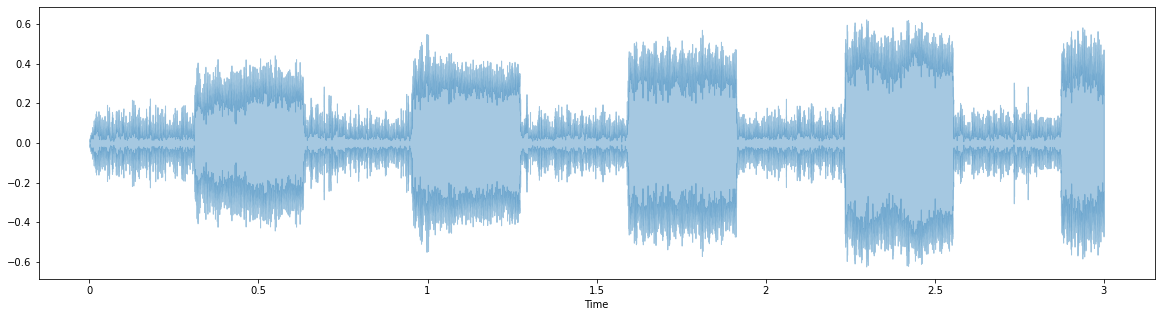

In [919]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(20, 5))
print(x.shape)
librosa.display.waveshow(x, sr=sr, alpha=0.4)


## Spectrogram

Let's display the spectrogram of this clip and pick a window to analyze


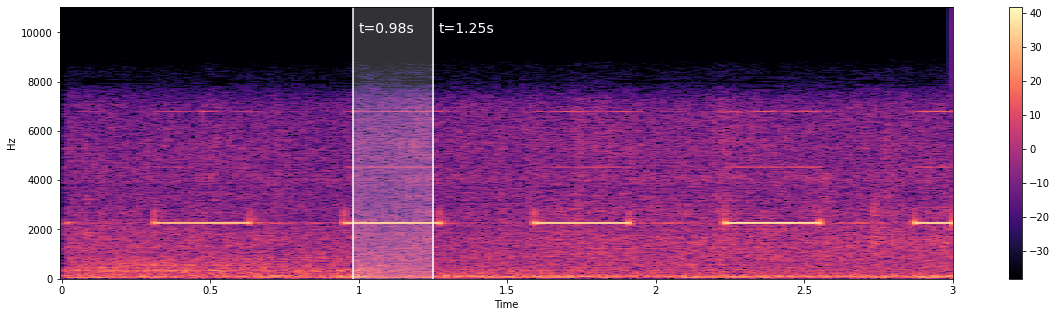

In [920]:
import numpy as np

n_fft = 2048//2
win_length = n_fft
hop_length = win_length // 4


# Calculate FFT in dB
X = librosa.stft(x, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
Xdb = librosa.amplitude_to_db(X)

# Plot Spectrogram
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, n_fft=n_fft, win_length=win_length,
                         hop_length=hop_length, x_axis='time', y_axis='hz', cmap="magma")
plt.colorbar()


# Window to analyze
window_t = (0.98, 1.25)
plt.axvspan(xmin=window_t[0], xmax=window_t[1], color='w', alpha=0.2)

for time in window_t:
    plt.axvline(x=time, color='w')
    plt.text(x=time+.02, y=10000, s=f"t={time}s", color='w', size=14)


## FFT Plot / Peaks

OK, it looks like we have a tone somewhere around 2200Hz (and `f*3`) and we've identified a window to analyze. Let's do an FFT plot and see if we can find a tone at `f*2`

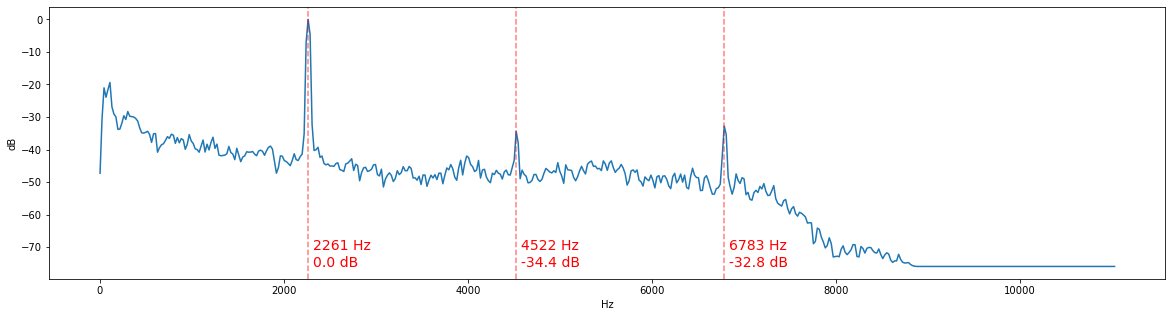

In [921]:
# https://stackoverflow.com/a/63351314/1130342
from scipy.signal import argrelextrema

# Window FFT spectrogram
window_i = librosa.core.time_to_frames(
    [window_t[0], window_t[1]], sr=sr, n_fft=n_fft, hop_length=hop_length)
window_Xdb = Xdb[:, window_i[0]:window_i[1]]

# Average the window, set peak to 0 dB
Xdb_mean = np.mean(window_Xdb, axis=1)
Xdb_mean = Xdb_mean - max(Xdb_mean)

frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

# Plot average frequency amplitudes across window
plt.figure(figsize=(20, 5))
plt.plot(frequencies, Xdb_mean, )
plt.xlabel('Hz')
plt.ylabel('dB')


# Plot local maxima
local_maxima = argrelextrema(Xdb_mean, np.greater, order=100)[0]
peaks = np.column_stack(
    (local_maxima, frequencies[local_maxima], Xdb_mean[local_maxima]))


for _, f, db in peaks:
    plt.axvline(x=f, color='r', alpha=0.5, linestyle='--')
    plt.text(x=f+50, y=min(Xdb_mean),
             s=f"{round(f)} Hz\n{db:.1f} dB", color='r', size=14)


## Onset Detection

Let's detect tone onset so we can replicate the period of the beeps

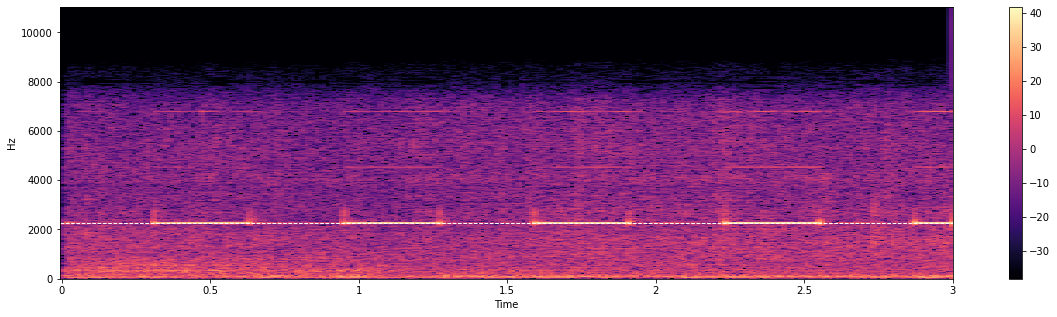

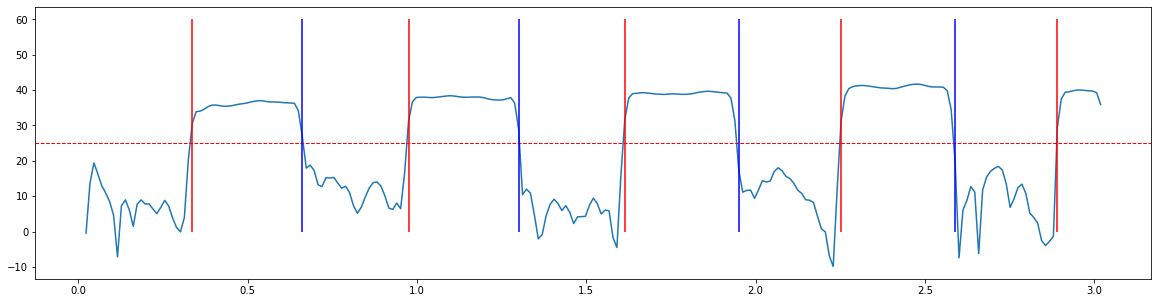

In [922]:

# Select the first peak
index, frequency, db = peaks[0]
index = int(index)

# Plot the spectrogram again, with the target peak highlighted
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, n_fft=n_fft, win_length=win_length,
                         hop_length=hop_length, x_axis='time', y_axis='hz', cmap="magma")
plt.colorbar()
plt.axhline(frequency, xmin=0, xmax=3, color='w', linewidth=1, linestyle='--')
plt.show()

# Select the FFT bin that matches this peak
fft_bin = Xdb[:][index][:]

# Plot the FFT bin over time, with the threshold line
plt.figure(figsize=(20, 5))
times = librosa.times_like(fft_bin,
                           sr=sr, n_fft=n_fft, hop_length=hop_length)
plt.plot(times, fft_bin)
db_target = 25
plt.axhline(db_target, xmin=0, xmax=3, color='r', linewidth=1, linestyle='--')


# Detect rise and fall
starts = np.array([])
ends = np.array([])
window_view = np.lib.stride_tricks.sliding_window_view(fft_bin, 2)

status = 'low'
for i, (a, b) in enumerate(window_view):
    if status is 'low':
        if a < b and b >= db_target:
            starts = np.append(starts, [times[i+1]])
            status = 'high'
    else:
        if b > a and b <= db_target:
            ends = np.append(ends, [times[i-1]])
            status = 'low'

# Show rise and fall lines
plt.vlines(starts, 0, 60, color='r')
plt.vlines(ends, 0, 60, color='b')


## Synthesis

Let's create a complex tone based on the FFT peaks and see how it sounds


In [923]:
import numpy as np

sr = 22050
T = 5.0
t = np.linspace(0, T, int(T*sr), endpoint=False)


x = 0
for _, f, db in peaks:
    x = x + librosa.db_to_amplitude(db) * np.sin(2*np.pi*f*t)

ipd.Audio(x, rate=sr)


## Verification

Let's verify synthesis with an FFT Plot


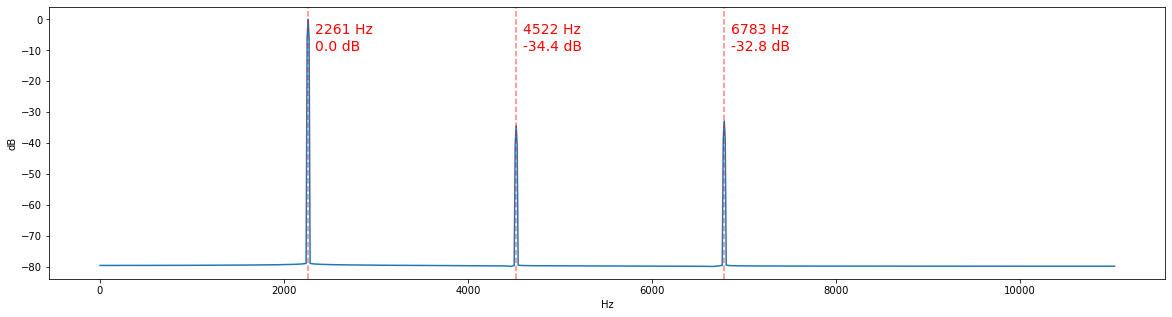

In [924]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(X)

# Average the frequency response over the entire duration
Xdb_mean = np.mean(Xdb, axis=1)
Xdb_mean = Xdb_mean - max(Xdb_mean)

frequencies = librosa.core.fft_frequencies(sr=sr)


# Plot average frequency amplitudes across window
plt.figure(figsize=(20, 5))
plt.plot(frequencies, Xdb_mean)
plt.xlabel('Hz')
plt.ylabel('dB')


# Plot local maxima
local_maxima = argrelextrema(Xdb_mean, np.greater, order=200)[0]
peaks = zip(frequencies[local_maxima], Xdb_mean[local_maxima])

for f, a in peaks:
    plt.axvline(x=f, color='r', alpha=0.5, linestyle='--')
    plt.text(x=f+75, y=max(Xdb_mean)-10,
             s=f"{round(f)} Hz\n{a:.1f} dB", color='r', size=14)


### Writing the tone


In [925]:
import soundfile as sf
sf.write('./out/backing-up-scania-r580-synthetic.wav', x, sr, 'PCM_24')


## Replicating the Period

TODO: get the period from the original recording and replicate it
